In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline

This workbook implements a logistic regression from scratch, as a learning exercise

Dependant variables are average number of "shots" and "passes" made by a player in a match.
Independant variable is position of player ("f" = forward, "d" = defender)

Methods based on https://beckernick.github.io/logistic-regression-from-scratch/

In [2]:
df = pd.read_csv('data/ffs_player_year.csv')
df = df.loc[df.pos.isin(['d','f']), ['pos', 'shots','passes']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 0 to 1732
Data columns (total 3 columns):
pos       942 non-null object
shots     942 non-null float64
passes    942 non-null float64
dtypes: float64(2), object(1)
memory usage: 29.4+ KB


In [3]:
def distplot_multi(df, x, y, c):
    '''seaborn jointgrid for multiple classes'''
    #sns.set()
    g = sns.JointGrid(x, y, df, size=8)
    labels=[]
    for c, c_group in df.groupby(c):
        sns.kdeplot(c_group[x], ax=g.ax_marg_x, legend=False, shade=True)
        sns.kdeplot(c_group[y], ax=g.ax_marg_y, legend=False, vertical=True, shade=True)
        g.ax_joint.plot(c_group[x], c_group[y], "o", ms=5, alpha=0.9, markeredgecolor='white', markeredgewidth=0.6)
        labels.append(c)
    g.ax_joint.legend(labels)

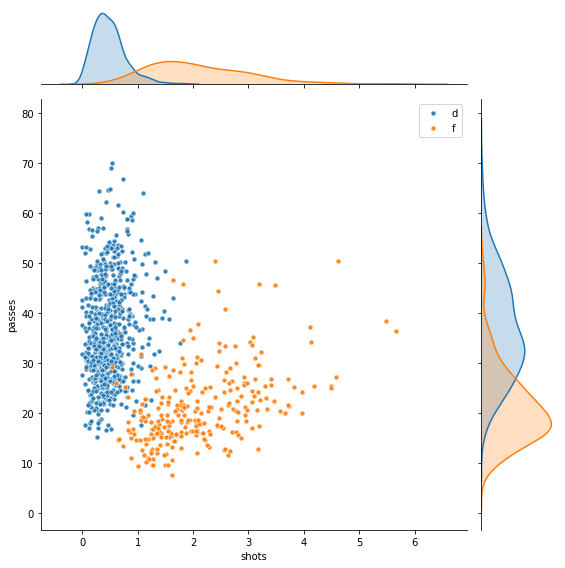

In [4]:
distplot_multi(df=df, x='shots', y='passes', c='pos')

In [5]:
df['y'] = df['pos'].apply(lambda x: 1 if x == 'd' else 0) 

X = df[['shots','passes']].values
Y = df[['y']].values.flatten() 

In [6]:
print(X.shape); print(Y.shape)

(942, 2)
(942,)


* We need some function that can "model" the probability of our dependant variable y, giving our observed independant variables x
* We define a linear function (y = w1x1 + w2x2 +...) and pass it through a sigmoid "link" function to bound the probability output values between 0,1

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logistic(w, x):
    return sigmoid(np.dot(w,x))

* We now have our raw model! 

* However we need to learn which weights (w) we should give to the coefficients of each dependant variable (and the bias), such that the predicted values are as close to the observed values as possible across all cases. 
* We define a likelihood function which compares the model predicted probability with the actual observed  probability (0 or 1), and try to find values for our coefficients which maximize the overall likelihood when applying these coefficients to *all* observations (equivalent to minimizing a cost function).
* In other words, we are trying to find the most likely coefficients, given the observed variables


We define this likelihood calculation for a single record below. 

In [8]:
def l_single(w, x, y):
    y_pred = logistic(w, x)
    return (y_pred ** y) * ((1 - y_pred) ** (1 - y))  

For example if out model predicts a high probability, and our actual value is 1, we achieve a large likelihood for that record.

In [9]:
x = np.array([1, 2])
w = np.array([2, 2])
y = 1 

print('y_pred:', logistic(w=w, x=x)) 
print('likelihood:', l_single(w=w, x=x, y=y)) 

('y_pred:', 0.99752737684336534)
('likelihood:', 0.99752737684336534)


However if we get a high probability and our actual value is 0 we will return a small likelihood for that record.

In [10]:
y = 0

print('y_pred:', logistic(w=w, x=x)) 
print('likelihood:', l_single(w=w, x=x, y=y))

('y_pred:', 0.99752737684336534)
('likelihood:', 0.0024726231566346568)


But we don't want weights which are only appropriate for a single record, we want weights which result in predictions which are as close to their actual values for as many records as possible. To do this we calculate the product of the likelihood for all records, and try to find weights which maximize this. 

In [11]:
def likelihood(w, X, Y):
    return np.product(ll_single(w, x, y) for x, y in zip(X, Y))

We now have now defined our objective function which we will try to maximize. How do we find the weights which return the maximum likelihood? 

Using (smart) trial and error!

We use the fact that we can differentiate our objective function with respect to **w**.

This tells us both the rate, and more importantly, direction of change in L, when we change **w**.
So if we try some values of w and see that dl/dw is positive, we have confidence that on our next guess if we use a larger value of w, L will increase. Likewise if this GRADIENT is negative we should decrease w. 

We continue going like this,  making incremental changes until the gradient starts to get so small that making any more update will not give us any more benefit. In this case our objective function has been maximized and we have found our optimised w. 

The case described above is called gradient ascent, in the case of an objective function which we are trying to minimize (e.g. Sum of squared error) we move in the opposite direction at each update.

However, the likelihood function we have described above can be differentiated much more easily if we first apply a log transformation which we will do. As the log is a monotonic function (strictly increasing) we know it will be maximized at the same point as the original function. 

In [12]:
def log_likelihood(w, X, Y):
    return np.sum(np.log(l_single(w, x, y)) for x, y in zip(X, Y))

We can simplify this even further (note the reduced sigmoid) 

In [13]:
def ll_single(w, x, y):
    return (y*np.dot(w,x)) - np.log(1 + np.exp(np.dot(w,x)))

def log_likelihood(w, X, Y):
    return np.sum(ll_single(w, x, y) for x, y in zip(X, Y))

We can now differentiate this with respect to each parameter in w, to get the gradients for our objective function (log likelihood). Note that in the case where we have more than 1 parameter e.g. len(w) > 1 then we return a system of simultaneous equations, with each being the partial derivative for a specific parameter. Each equation can be roughly interpreted as the rate of change of our objective function for when changing that specific parameter, at (around) its current values. So if we get a gradient value of 2 for a parameter we can say that making a small increase in that w value will increase our objective function (log likelihood). 

This means that each step does not necessarily update all weights in the same direction (e.g. some may increase whilst others decrease), as each parameter will have its own gradient. As such, our gradient function returns a vector of length w, containing the gradients for each parameter, which we then multiply by our step size and add (or in the case of minimizing our cost function, subtract) to our current weights. 

We then compute the new log likelihood using our updated weights and stop our gradient updates when our log likelihood has reached a pre-determined threshold (our parameters are optimized) 

In [14]:
def g_single(w, x, y):
    return x * (y - logistic(w, x)) 

def gradient(w, X, Y):
    return np.sum(g_single(w, x, y) for x, y in zip(X, Y))

# or

def gradient(w, X, Y):
    predictions = logistic(w, x) 
    return X.T.dot(y - predictions) 

In [15]:
def fit_logistic_regression(X, Y, step_size, steps_limit):
    # append bias to features 
    bias = np.ones((X.shape[0], 1))
    X = np.hstack((bias, X))
    w = np.zeros(X.shape[1]) 
    
    for i in range(steps_limit):
        predictions = sigmoid(np.dot(X, w))
        gradients = np.dot(X.T, Y - predictions)
        w += gradients * step_size
        if i % 2000 == 0:
            print('Step:', i) 
            print('Log likelihood:', log_likelihood(w, X, Y))
            print('Weights:', w)     
    return w
        
           
#def fit_logistic_regression(w, X, y, steps, step_size):
    #for _ in range(steps): w += step_size * np.dot(X.T, y - (1 / (1 + np.exp(-np.dot(X, w))))) 

In [16]:
w = fit_logistic_regression(X, Y, 1e-5, 20000) 

('Step:', 0)
('Log likelihood:', -612.45094990149141)
('Weights:', array([ 0.00203   , -0.00115528,  0.09520574]))
('Step:', 2000)
('Log likelihood:', -114.94835213375141)
('Weights:', array([-0.4140591 , -2.22443164,  0.13512279]))
('Step:', 4000)
('Log likelihood:', -88.554616308551431)
('Weights:', array([-0.52436269, -2.93172502,  0.16530566]))
('Step:', 6000)
('Log likelihood:', -78.132188005110265)
('Weights:', array([-0.57970338, -3.38214736,  0.18404603]))
('Step:', 8000)
('Log likelihood:', -72.476408589332564)
('Weights:', array([-0.61090474, -3.71580762,  0.19762766]))
('Step:', 10000)
('Log likelihood:', -68.922537073716711)
('Weights:', array([-0.62864696, -3.9811361 ,  0.20821224]))
('Step:', 12000)
('Log likelihood:', -66.489378758782564)
('Weights:', array([-0.63791948, -4.20109544,  0.21682006]))
('Step:', 14000)
('Log likelihood:', -64.72633741844659)
('Weights:', array([-0.64145485, -4.38852748,  0.22401953]))
('Step:', 16000)
('Log likelihood:', -63.396153925101942)